# <center>TCGA-LUAD</center>

## Abstract 

## Main Code

In [1]:
# Importing Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

# models tried
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import Perceptron

In [2]:
# Opening the dataset
df = pd.read_table("processed_squamous.txt", sep=" ")
y = df.label
X = df.drop('label', axis=1) #iloc[:,list(range(df.shape[1]-1))]
# features in columns and samples in rows.

In [3]:
print(df.shape)
print(X.shape)
print(y.shape)
y.describe()

(551, 917)
(551, 916)
(551,)


count       551
unique        2
top       tumor
freq        502
Name: label, dtype: object

In [4]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(440, 916)
(440,)
(111, 916)
(111,)


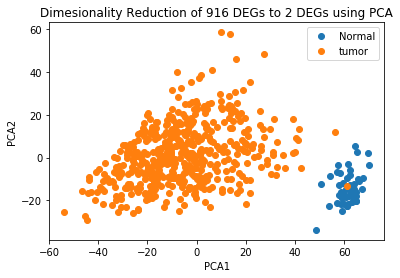

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
# plt.scatter(X_pca[:,0],X_pca[:,1])

df2 = pd.DataFrame(dict(x=X_pca[:,0], y=X_pca[:,1], label=y))

groups = df2.groupby('label')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='.', linestyle='', ms=12, label=name)
ax.legend()
plt.title('Dimesionality Reduction of 916 DEGs to 2 DEGs using PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

plt.show()

In [25]:
def try_model(model):
    clf_model = model
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
#     print('Model:', str(model).split('(')[0])
#     print('Model parameters:', str(model))
#     print('confusion matrix', confusion_matrix(y_test,y_pred), sep='\n')
#     print(classification_report(y_test,y_pred))
#     print('accuracy score =', accuracy_score(y_test,y_pred))
#     print()
    return (str(model).split('(')[0], accuracy_score(y_test,y_pred))

### Model #1: SVM

In [7]:
# SVM model (building the model [Linear])
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
# testing the model
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[ 10   0]
 [  1 100]]
              precision    recall  f1-score   support

      Normal       0.91      1.00      0.95        10
       tumor       1.00      0.99      1.00       101

    accuracy                           0.99       111
   macro avg       0.95      1.00      0.97       111
weighted avg       0.99      0.99      0.99       111

0.990990990990991


In [8]:
# GridSearch
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 
# {'kernel':('linear', 'rbf'), 'C':[1, 10]}

grid = GridSearchCV(svclassifier, parameters)
grid.fit(X_train, y_train)
print(grid.best_params_)
print()
print(grid.best_estimator_) 
y_pred_2 = grid.predict(X_test)
print(confusion_matrix(y_test,y_pred_2))
print(classification_report(y_test,y_pred_2))
print(accuracy_score(y_test,y_pred_2))

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
[[  8   2]
 [  1 100]]
              precision    recall  f1-score   support

      Normal       0.89      0.80      0.84        10
       tumor       0.98      0.99      0.99       101

    accuracy                           0.97       111
   macro avg       0.93      0.90      0.91       111
weighted avg       0.97      0.97      0.97       111

0.972972972972973


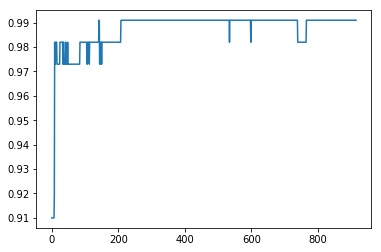

In [9]:
# No. of features vs. accuracy
acc_list = []
for i in range(1, df.shape[1]-1):
    X = df.iloc[:,list(range(i))]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    svc = SVC(kernel='linear')
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc_list.append(accuracy_score(y_test,y_pred))
    
plt.plot(acc_list)
plt.show()

### Model #2: Linear Discriminant Analysis

In [10]:
param = {'solver' : ['svd','lsqr']}
lda = LinearDiscriminantAnalysis()

# building a basic model
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print()


# performing grid search analysis of the model
grid = GridSearchCV(lda, param)
grid.fit(X_train, y_train)
print(grid.best_params_)
print()
print(grid.best_estimator_) 
y_pred_2 = grid.predict(X_test)
print(confusion_matrix(y_test,y_pred_2))
print(classification_report(y_test,y_pred_2))
print(accuracy_score(y_test,y_pred_2))


[[ 9  1]
 [ 2 99]]
              precision    recall  f1-score   support

      Normal       0.82      0.90      0.86        10
       tumor       0.99      0.98      0.99       101

    accuracy                           0.97       111
   macro avg       0.90      0.94      0.92       111
weighted avg       0.97      0.97      0.97       111

0.972972972972973

{'solver': 'svd'}

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
[[ 9  1]
 [ 2 99]]
              precision    recall  f1-score   support

      Normal       0.82      0.90      0.86        10
       tumor       0.99      0.98      0.99       101

    accuracy                           0.97       111
   macro avg       0.90      0.94      0.92       111
weighted avg       0.97      0.97      0.97       111

0.972972972972973


### Model #3: Logistic Regression

In [11]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print()

[[ 10   0]
 [  1 100]]
              precision    recall  f1-score   support

      Normal       0.91      1.00      0.95        10
       tumor       1.00      0.99      1.00       101

    accuracy                           0.99       111
   macro avg       0.95      1.00      0.97       111
weighted avg       0.99      0.99      0.99       111

0.990990990990991



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Model #4: Naive Bayes

In [12]:
NB = GaussianNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print()

[[  7   3]
 [  0 101]]
              precision    recall  f1-score   support

      Normal       1.00      0.70      0.82        10
       tumor       0.97      1.00      0.99       101

    accuracy                           0.97       111
   macro avg       0.99      0.85      0.90       111
weighted avg       0.97      0.97      0.97       111

0.972972972972973



In [13]:
try_model(GaussianNB())

Model: GaussianNB
Model parameters: GaussianNB(priors=None, var_smoothing=1e-09)
confusion matrix
[[  7   3]
 [  0 101]]
              precision    recall  f1-score   support

      Normal       1.00      0.70      0.82        10
       tumor       0.97      1.00      0.99       101

    accuracy                           0.97       111
   macro avg       0.99      0.85      0.90       111
weighted avg       0.97      0.97      0.97       111

accuracy score = 0.972972972972973



### Model #5: Decision Tree Classifier

In [14]:
try_model(DecisionTreeClassifier())

Model: DecisionTreeClassifier
Model parameters: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
confusion matrix
[[10  0]
 [ 2 99]]
              precision    recall  f1-score   support

      Normal       0.83      1.00      0.91        10
       tumor       1.00      0.98      0.99       101

    accuracy                           0.98       111
   macro avg       0.92      0.99      0.95       111
weighted avg       0.98      0.98      0.98       111

accuracy score = 0.9819819819819819



[[10  0]
 [ 2 99]]
              precision    recall  f1-score   support

      Normal       0.83      1.00      0.91        10
       tumor       1.00      0.98      0.99       101

    accuracy                           0.98       111
   macro avg       0.92      0.99      0.95       111
weighted avg       0.98      0.98      0.98       111

0.9819819819819819
1



[Text(167.4, 163.07999999999998, 'X[13] <= 13.988\ngini = 0.162\nsamples = 440\nvalue = [39, 401]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 401\nvalue = [0, 401]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 39\nvalue = [39, 0]')]

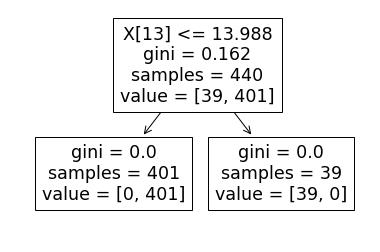

In [15]:
DTC = DecisionTreeClassifier()
dtc = DTC.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(dtc.n_outputs_)
print()
plot_tree(dtc)

### Model #6: Perceptron

In [16]:
clf = Perceptron()
clf.fit(X, y)
clf.score(X, y)

0.9981851179673321

In [17]:
try_model(Perceptron())

Model: Perceptron
Model parameters: Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
confusion matrix
[[ 10   0]
 [  1 100]]
              precision    recall  f1-score   support

      Normal       0.91      1.00      0.95        10
       tumor       1.00      0.99      1.00       101

    accuracy                           0.99       111
   macro avg       0.95      1.00      0.97       111
weighted avg       0.99      0.99      0.99       111

accuracy score = 0.990990990990991



In [34]:
models = [SVC(kernel='linear'), LinearDiscriminantAnalysis(), LogisticRegression(), GaussianNB(), DecisionTreeClassifier(), Perceptron()]
model_results = {}
for model in models:
    key, val = try_model(model)
    model_results[key] = val
print(model_results)

{'SVC': 0.990990990990991, 'LinearDiscriminantAnalysis': 0.972972972972973, 'LogisticRegression': 0.990990990990991, 'GaussianNB': 0.972972972972973, 'DecisionTreeClassifier': 0.9819819819819819, 'Perceptron': 0.990990990990991}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [51]:
df2 = pd.DataFrame(list(model_results.values()), list(model_results.keys()))
df2.
    
df2

,0
SVC,0.990991
LinearDiscriminantAnalysis,0.972973
LogisticRegression,0.990991
GaussianNB,0.972973
DecisionTreeClassifier,0.981982
Perceptron,0.990991


## Results and Discussion